!pip install -q transformers datasets accelerate pillow requests tqdm pandas
!pip install -q torch torchvision
!pip install -q huggingface_hub

In [9]:
!pip install -q transformers datasets accelerate pillow requests tqdm pandas
!pip install -q torch torchvision scikit-learn
!pip install -q huggingface_hub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

Load quoran dataset

In [11]:
# Load the Quran dataset from Hugging Face
dataset = load_dataset("mohammed-almaamari/quran-dataset", split="train")

# Convert to pandas for easier manipulation
df = dataset.to_pandas()

print(f"Dataset loaded with {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head()

Repo card metadata block was not found. Setting CardData to empty.


Dataset loaded with 6236 rows
Columns: ['audio_path', 'surah_number', 'surah_name', 'surah_english_name', 'surah_english_translation', 'revelation_type', 'aya_number', 'aya_text', 'page', 'juz_number', 'manzil', 'hizb_number', 'ruku_number', 'quarter_number', 'sajda', 'aya_image']


,audio_path,surah_number,surah_name,surah_english_name,surah_english_translation,revelation_type,aya_number,aya_text,page,juz_number,manzil,hizb_number,ruku_number,quarter_number,sajda,aya_image
0,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-1-...
1,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-2-...
2,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,3,الرَّحْمَٰنِ الرَّحِيمِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-3-...
3,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,4,مَالِكِ يَوْمِ الدِّينِ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-4-...
4,https://everyayah.com/data/Muhammad_Ayyoub_128...,1,سُورَةُ ٱلْفَاتِحَةِ,Al-Faatiha,The Opening,Meccan,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,1,1,1,1,1,1,None,https://surahquran.com/img/Ayat-green/verse-5-...


dataset structure

In [12]:
print("Dataset Schema:")
print("-" * 50)
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

print("\n" + "=" * 50)
print("Sample row:")
print(df.iloc[0].to_dict())

print("\n" + "=" * 50)
print(f"Total Surahs: {df['surah_number'].nunique()}")
print(f"Total Ayahs: {len(df)}")
print(f"Revelation types: {df['revelation_type'].unique()}")

Dataset Schema:
--------------------------------------------------
audio_path: object
surah_number: int64
surah_name: object
surah_english_name: object
surah_english_translation: object
revelation_type: object
aya_number: int64
aya_text: object
page: int64
juz_number: int64
manzil: int64
hizb_number: int64
ruku_number: int64
quarter_number: int64
sajda: object
aya_image: object

Sample row:
{'audio_path': 'https://everyayah.com/data/Muhammad_Ayyoub_128kbps/001001.mp3', 'surah_number': 1, 'surah_name': 'سُورَةُ ٱلْفَاتِحَةِ', 'surah_english_name': 'Al-Faatiha', 'surah_english_translation': 'The Opening', 'revelation_type': 'Meccan', 'aya_number': 1, 'aya_text': 'بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ', 'page': 1, 'juz_number': 1, 'manzil': 1, 'hizb_number': 1, 'ruku_number': 1, 'quarter_number': 1, 'sajda': None, 'aya_image': 'https://surahquran.com/img/Ayat-green/verse-1-surah-1.png'}

Total Surahs: 114
Total Ayahs: 6236
Revelation types: ['Meccan' 'Medinan']


Testing image download: https://surahquran.com/img/Ayat-green/verse-1-surah-1.png
Success! Image size: (1080, 477)


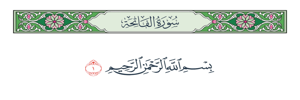

In [13]:
import hashlib

def download_image(url, cache_dir="./quran_images"):
    """Download image from URL with caching"""
    os.makedirs(cache_dir, exist_ok=True)

    # Create cache filename from URL hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    cache_path = os.path.join(cache_dir, f"{url_hash}.png")

    # Check if already cached
    if os.path.exists(cache_path):
        try:
            return Image.open(cache_path).convert("RGB")
        except:
            pass

    # Download image
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(cache_path)
        return img
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None

# Test downloading a single image
test_url = df['aya_image'].iloc[0]
print(f"Testing image download: {test_url}")
test_img = download_image(test_url)
if test_img:
    print(f"Success! Image size: {test_img.size}")
    display(test_img.resize((300, 100)))

In [14]:
def create_ocr_sample(row):
    """Create an OCR training sample from a dataset row"""

    # The image shows the ayah text, model should extract it
    prompt = "<image>\nاستخرج النص القرآني من هذه الصورة."

    # The expected output is the ayah text with metadata
    response = f"""النص: {row['aya_text']}
السورة: {row['surah_name']} ({row['surah_english_name']})
رقم الآية: {row['aya_number']}
الصفحة: {row['page']}
الجزء: {row['juz_number']}
الحزب: {row['hizb_number']}"""

    if pd.notna(row['sajda']) and row['sajda']:
        response += f"\nسجدة: {row['sajda']}"

    return {
        "prompt": prompt,
        "response": response,
        "image_url": row['aya_image'],
        "surah_number": row['surah_number'],
        "aya_number": row['aya_number'],
        "aya_text": row['aya_text']
    }

# Create samples for all rows
samples = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Creating samples"):
    sample = create_ocr_sample(row)
    samples.append(sample)

print(f"Created {len(samples)} training samples")
print("\nExample sample:")
print(json.dumps(samples[0], ensure_ascii=False, indent=2))

Creating samples: 100%|██████████| 6236/6236 [00:00<00:00, 57324.12it/s]

Created 6236 training samples

Example sample:
{
  "prompt": "<image>\nاستخرج النص القرآني من هذه الصورة.",
  "response": "النص: بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ\nالسورة: سُورَةُ ٱلْفَاتِحَةِ (Al-Faatiha)\nرقم الآية: 1\nالصفحة: 1\nالجزء: 1\nالحزب: 1",
  "image_url": "https://surahquran.com/img/Ayat-green/verse-1-surah-1.png",
  "surah_number": 1,
  "aya_number": 1,
  "aya_text": "بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ"
}


In [15]:
def create_multi_task_samples(row):
    """Create multiple task variations for each ayah"""
    samples = []

    # Task 1: Simple OCR - Extract text only
    samples.append({
        "task": "ocr",
        "prompt": "<image>\nExtract the Quranic text from this image.",
        "response": row['aya_text'],
        "image_url": row['aya_image']
    })

    # Task 2: Full metadata extraction
    samples.append({
        "task": "metadata",
        "prompt": "<image>\nExtract all information from this Quran ayah image.",
        "response": f"""Ayah Text: {row['aya_text']}
Surah: {row['surah_name']} ({row['surah_english_translation']})
Surah Number: {row['surah_number']}
Ayah Number: {row['aya_number']}
Page: {row['page']}
Juz: {row['juz_number']}
Hizb: {row['hizb_number']}
Manzil: {row['manzil']}
Ruku: {row['ruku_number']}
Quarter: {row['quarter_number']}
Revelation Type: {row['revelation_type']}""",
        "image_url": row['aya_image']
    })

    # Task 3: Arabic OCR
    samples.append({
        "task": "arabic_ocr",
        "prompt": "<image>\nاقرأ النص العربي في هذه الصورة.",
        "response": row['aya_text'],
        "image_url": row['aya_image']
    })

    return samples

# Create multi-task samples for a subset
multi_task_samples = []
for idx, row in tqdm(df.head(100).iterrows(), total=100, desc="Creating multi-task samples"):
    multi_task_samples.extend(create_multi_task_samples(row))

print(f"Created {len(multi_task_samples)} multi-task samples from 100 ayahs")

Creating multi-task samples: 100%|██████████| 100/100 [00:00<00:00, 38255.24it/s]

Created 300 multi-task samples from 100 ayahs


In [16]:
class QuranOCRDataset(Dataset):
    def __init__(self, samples, cache_dir="./quran_images", max_samples=None):
        self.samples = samples[:max_samples] if max_samples else samples
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.samples)

    def download_image(self, url):
        try:
            filename = hashlib.md5(url.encode()).hexdigest() + ".jpg"
            filepath = os.path.join(self.cache_dir, filename)
            if os.path.exists(filepath):
                return Image.open(filepath).convert("RGB")
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert("RGB")
                img.save(filepath)
                return img
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        return None

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = self.download_image(sample['image_url'])
        return {
            'image': image,
            'prompt': sample['prompt'],
            'response': sample['response'],
            'image_url': sample['image_url']
        }
print("QuranOCRDataset class defined")

QuranOCRDataset class defined


In [17]:
def save_training_data(samples, output_path="quran_ocr_training.json"):
    """Save training samples to JSON format"""

    # Format for training
    training_data = []
    for sample in samples:
        training_data.append({
            "conversations": [
                {
                    "role": "<|User|>",
                    "content": sample['prompt'],
                    "images": [sample['image_url']]
                },
                {
                    "role": "<|Assistant|>",
                    "content": sample['response']
                }
            ]
        })

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(training_data, f, ensure_ascii=False, indent=2)

    print(f"Saved {len(training_data)} samples to {output_path}")
    return output_path

# Save training data
save_training_data(samples[:1000], "quran_ocr_training.json")

Saved 1000 samples to quran_ocr_training.json


'quran_ocr_training.json'

In [18]:
from sklearn.model_selection import train_test_split

# Create stratified split by surah
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['surah_number']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create samples for each split
train_samples = [create_ocr_sample(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))]
val_samples = [create_ocr_sample(row) for _, row in tqdm(val_df.iterrows(), total=len(val_df))]

# Save splits
save_training_data(train_samples, "quran_ocr_train.json")
save_training_data(val_samples, "quran_ocr_val.json")

Training samples: 5612
Validation samples: 624


100%|██████████| 624/624 [00:00<00:00, 52075.16it/s]


Saved 5612 samples to quran_ocr_train.json
Saved 624 samples to quran_ocr_val.json


'quran_ocr_val.json'

In [19]:
# Create and test dataset instance (after train_samples is defined)
train_dataset_test = QuranOCRDataset(train_samples[:100], max_samples=100)
print(f"Dataset size: {len(train_dataset_test)}")

# Test loading a sample
test_sample = train_dataset_test[0]
if test_sample['image']:
    print(f"Image loaded: {test_sample['image'].size}")
    print(f"Prompt: {test_sample['prompt']}")
    print(f"Response preview: {test_sample['response'][:200]}...")

Dataset size: 100
Image loaded: (1080, 586)
Prompt: <image>
استخرج النص القرآني من هذه الصورة.
Response preview: النص: لِنُرِيَكَ مِنْ آيَاتِنَا الْكُبْرَى
السورة: سُورَةُ طه (Taa-Haa)
رقم الآية: 23
الصفحة: 313
الجزء: 16
الحزب: 32...


In [20]:
!pip install -q qwen-vl-utils transformers>=4.45.0 accelerate model

import sys
import gc
sys.path.insert(0, '.')

# Clear memory
gc.collect()
if 'model' in dir():
    del model
if torch.backends.mps.is_available():
    torch.mps.empty_cache()


from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import transformers

print(f"Transformers version: {transformers.__version__}")

# Model configuration
model_path = "Qwen/Qwen2-VL-2B-Instruct"

# Detect device
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    torch_dtype = torch.float16
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using Apple MPS (Metal Performance Shaders)")
    torch_dtype = torch.float32  # MPS works better with float32
else:
    device = "cpu"
    print("Using CPU only")
    torch_dtype = torch.float32

print(f"Device: {device}, Dtype: {torch_dtype}")

# Load processor
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

# Load model
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch_dtype,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)
model = model.to(device)

print(f"Model loaded: {model_path}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")

# For compatibility
tokenizer = processor.tokenizer

zsh:1: 4.45.0 not found
Transformers version: 4.56.2
Using Apple MPS (Metal Performance Shaders)
Device: mps, Dtype: torch.float32


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded: Qwen/Qwen2-VL-2B-Instruct
Model parameters: 2.21B


Test inference on Quran image


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Testing inference on first ayah:
Expected text: بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ
Device: mps


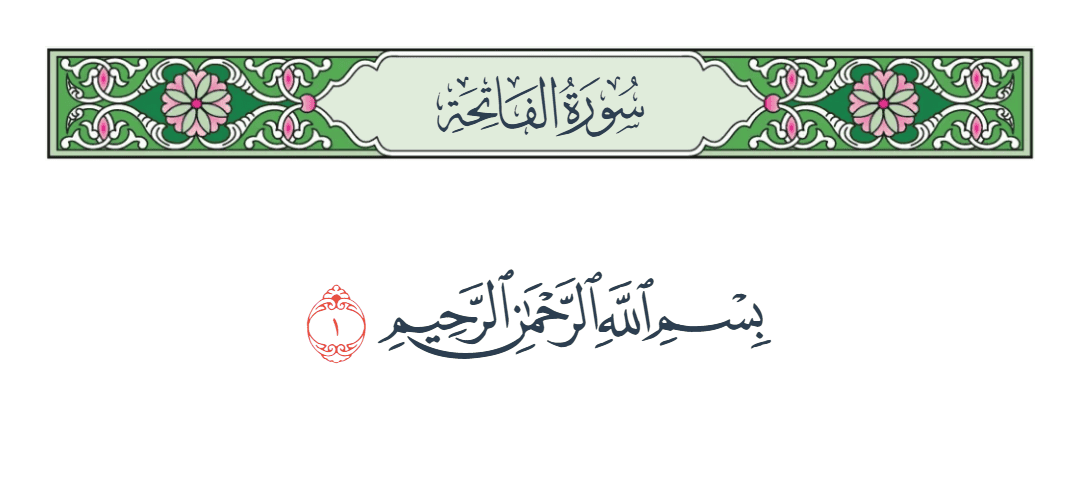

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model output: The Quranic text from the image is:

سورة الفاتحة


In [21]:
!pip install qwen-vl-utils

from qwen_vl_utils import process_vision_info

def test_inference(model, processor, image_url, prompt):
    """Run inference on a single image - cross-platform compatible"""

    # Download image from URL
    response = requests.get(image_url, timeout=30)
    image = Image.open(BytesIO(response.content)).convert("RGB")

    # Display image
    display(image)

    # Qwen2-VL message format
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt}
            ]
        }
    ]

    # Prepare inputs
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )

    # Move to device
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False
        )

    # Decode only the generated part
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    return output_text

# Test on first ayah
test_url = df['aya_image'].iloc[0]
test_prompt = "Extract the Quranic text from this image. Return only the Arabic text."

print("Testing inference on first ayah:")
print(f"Expected text: {df['aya_text'].iloc[0]}")
print(f"Device: {device}")

result = test_inference(model, processor, test_url, test_prompt)
print(f"Model output: {result}")

LORA finetuning

In [22]:
!pip install -q peft

from peft import LoraConfig, get_peft_model

# LoRA configuration for Qwen2-VL
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable_params:,} / {all_params:,} ({100 * trainable_params / all_params:.2f}%)")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Trainable: 18,464,768 / 2,227,450,368 (0.83%)


Training config

In [23]:
from qwen_vl_utils import process_vision_info

class QuranOCRDataset(Dataset):
    def __init__(self, samples, processor, cache_dir="./quran_images", max_samples=None):
        self.samples = samples[:max_samples] if max_samples else samples
        self.processor = processor
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.samples)

    def download_image(self, url):
        try:
            filename = hashlib.md5(url.encode()).hexdigest() + ".jpg"
            filepath = os.path.join(self.cache_dir, filename)
            if os.path.exists(filepath):
                return Image.open(filepath).convert("RGB")
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert("RGB")
                img.save(filepath)
                return img
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        return None

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = self.download_image(sample['image_url'])

        if image is None:
            return None

        return {
            'image': image,
            'prompt': "Extract the Quranic text from this image.",
            'response': sample['aya_text'],
            'full_response': sample['response']
        }

# Create dataset instances
train_dataset = QuranOCRDataset(train_samples, processor, max_samples=1000)
val_dataset = QuranOCRDataset(val_samples, processor, max_samples=100)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 1000
Val dataset size: 100


Data collector

In [29]:
def collate_fn(batch, processor, device):

    # Filter out None samples
    batch = [b for b in batch if b is not None and b['image'] is not None]

    if not batch:
        return None

    all_images = []
    all_responses = []

    for sample in batch:
        # Resize image to reduce memory and token count
        img = sample['image']
        img.thumbnail((384, 384), Image.LANCZOS)
        all_images.append(img)
        all_responses.append(sample['response'])

    # Build full conversation with response for training
    full_texts = []
    for i, sample in enumerate(batch):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": all_images[i]},
                    {"type": "text", "text": sample['prompt']}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample['response']}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        full_texts.append(text)

    # Process full conversation (input + response)
    inputs = processor(
        text=full_texts,
        images=all_images,
        padding=True,
        return_tensors="pt"
    )

    # For causal LM, labels = input_ids (shifted internally by the model)
    labels = inputs["input_ids"].clone()

    # Mask padding tokens in labels
    labels[labels == processor.tokenizer.pad_token_id] = -100

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "pixel_values": inputs["pixel_values"],
        "image_grid_thw": inputs.get("image_grid_thw"),
        "labels": labels
    }

print("Data collator defined with proper label alignment")

Data collator defined with proper label alignment


In [30]:
from functools import partial

# Create collate function with processor
collate_with_processor = partial(collate_fn, processor=processor, device=device)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_with_processor,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_with_processor,
    num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 1000
Val batches: 100


In [33]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

model.train()

# Enable gradient checkpointing
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})

# Ensure all LoRA parameters require gradients
for name, param in model.named_parameters():
    if "lora" in name.lower():
        param.requires_grad = True

# Verify trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer with lower learning rate
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=5e-6,
    weight_decay=0.01
)

num_training_steps = len(train_loader) * 3
scheduler = CosineAnnealingLR(optimizer, T_max=num_training_steps)

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        if batch is None:
            continue

        try:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "pixel_values": pixel_values,
                "labels": labels
            }

            if batch.get("image_grid_thw") is not None:
                model_inputs["image_grid_thw"] = batch["image_grid_thw"].to(device)

            # Forward pass
            outputs = model(**model_inputs)
            loss = outputs.loss

            if loss is None:
                print("Warning: loss is None")
                continue

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Clear MPS cache periodically
            if device == "mps" and num_batches % 10 == 0:
                torch.mps.empty_cache()

            total_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"OOM - skipping batch")
                optimizer.zero_grad()
                if device == "mps":
                    torch.mps.empty_cache()
                gc.collect()
                continue
            else:
                print(f"Error: {e}")
                optimizer.zero_grad()
                continue

    return total_loss / max(num_batches, 1)

print("Training functions defined with gradient")

Trainable parameters: 18,464,768
Training functions defined with gradient


Run training

In [34]:
num_epochs = 3
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Evaluate
    model.eval()
    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            if batch is None:
                continue

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "pixel_values": pixel_values,
                "labels": labels
            }

            if batch.get("image_grid_thw") is not None:
                model_inputs["image_grid_thw"] = batch["image_grid_thw"].to(device)

            try:
                outputs = model(**model_inputs)
                if outputs.loss is not None:
                    val_loss += outputs.loss.item()
                    num_val_batches += 1
            except Exception as e:
                print(f"Validation error: {e}")
                continue

    val_loss = val_loss / max(num_val_batches, 1)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained("./quran_ocr_best")
        processor.save_pretrained("./quran_ocr_best")
        print("Saved best model!")

print("\nTraining complete!")


Epoch 1/3
--------------------------------------------------


Training: 100%|██████████| 1000/1000 [28:33<00:00,  1.71s/it, loss=4.5834]


Training Loss: 5.0587


Validation: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


Validation Loss: 4.3809
Saved best model!

Epoch 2/3
--------------------------------------------------


Training: 100%|██████████| 1000/1000 [14:22<00:00,  1.16it/s, loss=4.4750]


Training Loss: 4.3195


Validation: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Validation Loss: 4.3316
Saved best model!

Epoch 3/3
--------------------------------------------------


Training: 100%|██████████| 1000/1000 [13:32<00:00,  1.23it/s, loss=4.9192]


Training Loss: 4.2988


Validation: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Validation Loss: 4.3266
Saved best model!

Training complete!


In [35]:
output_dir = "./quran_ocr_finetuned_final"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

# List saved files
for f in os.listdir(output_dir):
    size = os.path.getsize(os.path.join(output_dir, f)) / 1e6
    print(f"  {f}: {size:.2f} MB")

Model saved to ./quran_ocr_finetuned_final
  adapter_model.safetensors: 73.92 MB
  added_tokens.json: 0.00 MB
  tokenizer_config.json: 0.00 MB
  special_tokens_map.json: 0.00 MB
  tokenizer.json: 11.42 MB
  README.md: 0.01 MB
  merges.txt: 1.67 MB
  adapter_config.json: 0.00 MB
  chat_template.jinja: 0.00 MB
  vocab.json: 2.78 MB


In [36]:
def evaluate_ocr_accuracy(model, tokenizer, test_samples, num_samples=50):
    """Evaluate OCR accuracy on test samples"""

    results = []

    for sample in tqdm(test_samples[:num_samples], desc="Evaluating"):
        try:
            # Download image
            response = requests.get(sample['image_url'], timeout=30)
            image = Image.open(BytesIO(response.content)).convert("RGB")

            # Get prediction (simplified - would need full inference pipeline)
            expected = sample['aya_text']

            results.append({
                "expected": expected,
                "image_url": sample['image_url']
            })

        except Exception as e:
            continue

    return results

# Run evaluation
eval_results = evaluate_ocr_accuracy(model, tokenizer, val_samples, num_samples=20)
print(f"Evaluated {len(eval_results)} samples")

Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]

Evaluated 20 samples



Sample 1


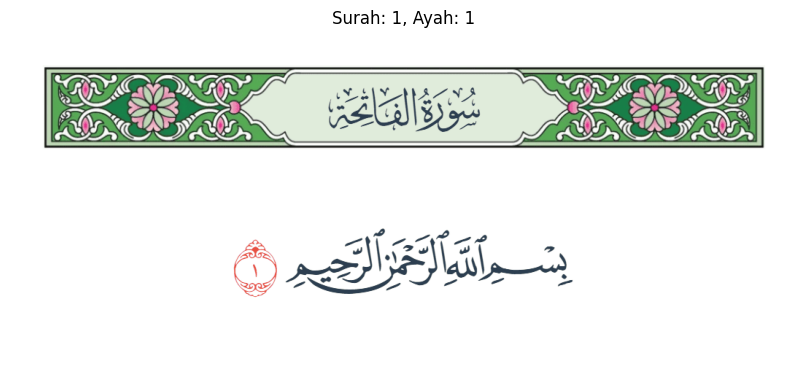

Expected: بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ

Sample 2


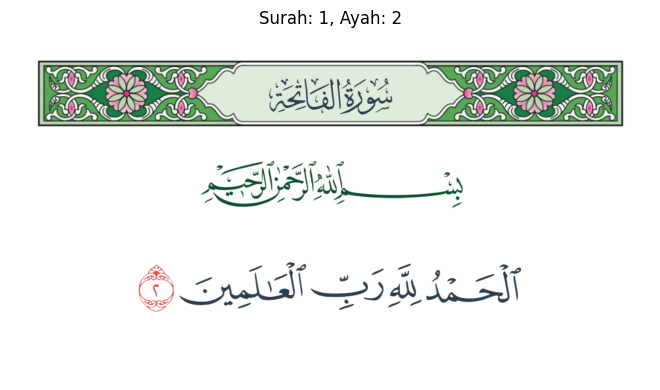

Expected: الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ

Sample 3


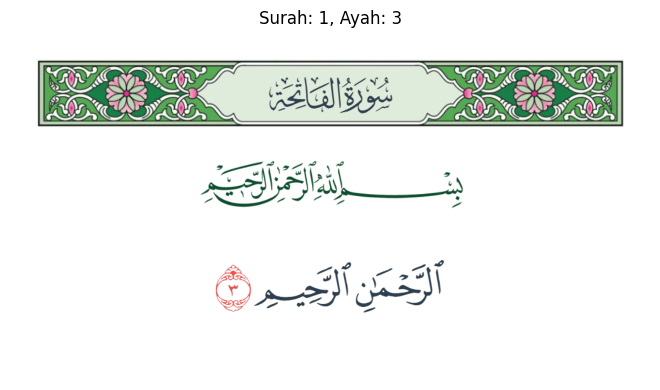

Expected: الرَّحْمَٰنِ الرَّحِيمِ


In [37]:
import matplotlib.pyplot as plt

def visualize_sample(sample, prediction=None):
    """Visualize a sample with its prediction"""

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    # Download and display image
    response = requests.get(sample['image_url'], timeout=30)
    image = Image.open(BytesIO(response.content))

    ax.imshow(image)
    ax.axis('off')

    title = f"Surah: {sample.get('surah_number', 'N/A')}, Ayah: {sample.get('aya_number', 'N/A')}"
    ax.set_title(title, fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"Expected: {sample['aya_text']}")
    if prediction:
        print(f"Predicted: {prediction}")

# Visualize a few samples
for i in range(3):
    print(f"\n{'='*50}")
    print(f"Sample {i+1}")
    print('='*50)
    visualize_sample(samples[i])